<img src="https://pbs.twimg.com/media/DEA1iygXsAAg7vC.jpg"/>

# **The Complete Pokemon Dataset | Clustering**
----

# Descripción  del conjunto de datos
Este conjunto de datos contiene observaciones asociadas con cada uno de los 802 pokémon de las siete generaciones de Pokémon. Los atributos de cada pokémon incluyen sus estadísticas básicas, rendimiento contra otros tipos de pokémon, altura, peso, clasificación, puntos de experiencia, habilidades, entre otros. Para obtener este conjunto de datos e información más detallada sobre sus atributos: https://www.kaggle.com/rounakbanik/pokemon

# Enfoque de análisis
Se desea agrupar los pokémon cuyas estadísticas básicas y otras caracteristicas sean más similares, con el objetivo de identificar cuáles serían los emparejamientos más balanceados en la escena competitiva de Pokémon. En otras palabras, dado un pokémon particular, con cuáles oponentes debería ser emparejado de forma que el combate sea justo para ambos.

# **Carga del conjunto de datos**

In [ ]:
from pandas import read_csv
from google.colab import drive

In [ ]:
# Debe subir el conjunto de datos a su cuenta de Google Drive y modificar la variable path. El conjunto de datos se obtiene en el enlace adjunto en la 
# descripción inicial.

drive.mount("/content/gdrive")
path = "/content/gdrive/MyDrive/AVGD/pokemon.csv"
df = read_csv(path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **Generalidades del conjunto de datos**
---

In [ ]:
df.head()

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,against_grass,against_ground,against_ice,against_normal,against_poison,against_psychic,against_rock,against_steel,against_water,attack,base_egg_steps,base_happiness,base_total,capture_rate,classfication,defense,experience_growth,height_m,hp,japanese_name,name,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,0.25,1.0,2.0,1.0,1.0,2.0,1.0,1.0,0.5,49,5120,70,318,45,Seed Pokémon,49,1059860,0.7,45,Fushigidaneフシギダネ,Bulbasaur,88.1,1,65,65,45,grass,poison,6.9,1,0
1,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,0.25,1.0,2.0,1.0,1.0,2.0,1.0,1.0,0.5,62,5120,70,405,45,Seed Pokémon,63,1059860,1.0,60,Fushigisouフシギソウ,Ivysaur,88.1,2,80,80,60,grass,poison,13.0,1,0
2,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,0.25,1.0,2.0,1.0,1.0,2.0,1.0,1.0,0.5,100,5120,70,625,45,Seed Pokémon,123,1059860,2.0,80,Fushigibanaフシギバナ,Venusaur,88.1,3,122,120,80,grass,poison,100.0,1,0
3,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,0.50,2.0,0.5,1.0,1.0,1.0,2.0,0.5,2.0,52,5120,70,309,45,Lizard Pokémon,43,1059860,0.6,39,Hitokageヒトカゲ,Charmander,88.1,4,60,50,65,fire,NaN,8.5,1,0
4,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,0.50,2.0,0.5,1.0,1.0,1.0,2.0,0.5,2.0,64,5120,70,405,45,Flame Pokémon,58,1059860,1.1,58,Lizardoリザード,Charmeleon,88.1,5,80,65,80,fire,NaN,19.0,1,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 41 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   abilities          801 non-null    object 
 1   against_bug        801 non-null    float64
 2   against_dark       801 non-null    float64
 3   against_dragon     801 non-null    float64
 4   against_electric   801 non-null    float64
 5   against_fairy      801 non-null    float64
 6   against_fight      801 non-null    float64
 7   against_fire       801 non-null    float64
 8   against_flying     801 non-null    float64
 9   against_ghost      801 non-null    float64
 10  against_grass      801 non-null    float64
 11  against_ground     801 non-null    float64
 12  against_ice        801 non-null    float64
 13  against_normal     801 non-null    float64
 14  against_poison     801 non-null    float64
 15  against_psychic    801 non-null    float64
 16  against_rock       801 non

In [ ]:
df.describe()

,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,against_grass,against_ground,against_ice,against_normal,against_poison,against_psychic,against_rock,against_steel,against_water,attack,base_egg_steps,base_happiness,base_total,defense,experience_growth,height_m,hp,percentage_male,pokedex_number,sp_attack,sp_defense,speed,weight_kg,generation,is_legendary
count,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,8.010000e+02,781.000000,801.000000,703.000000,801.000000,801.000000,801.000000,801.000000,781.000000,801.000000,801.000000
mean,0.996255,1.057116,0.968789,1.073970,1.068976,1.065543,1.135456,1.192884,0.985019,1.034020,1.098002,1.208177,0.887016,0.975343,1.005306,1.250312,0.983458,1.058365,77.857678,7191.011236,65.362047,428.377029,73.008739,1.054996e+06,1.163892,68.958801,55.155761,401.000000,71.305868,70.911361,66.334582,61.378105,3.690387,0.087391
std,0.597248,0.438142,0.353058,0.654962,0.522167,0.717251,0.691853,0.604488,0.558256,0.788896,0.738818,0.735356,0.266106,0.549375,0.495183,0.697148,0.500117,0.606562,32.158820,6558.220422,19.598948,119.203577,30.769159,1.602558e+05,1.080326,26.576015,20.261623,231.373075,32.353826,27.942501,28.907662,109.354766,1.930420,0.282583
min,0.250000,0.250000,0.000000,0.000000,0.250000,0.000000,0.250000,0.250000,0.000000,0.250000,0.000000,0.250000,0.000000,0.000000,0.000000,0.250000,0.250000,0.250000,5.000000,1280.000000,0.000000,180.000000,5.000000,6.000000e+05,0.100000,1.000000,0.000000,1.000000,10.000000,20.000000,5.000000,0.100000,1.000000,0.000000
25%,0.500000,1.000000,1.000000,0.500000,1.000000,0.500000,0.500000,1.000000,1.000000,0.500000,1.000000,0.500000,1.000000,0.500000,1.000000,1.000000,0.500000,0.500000,55.000000,5120.000000,70.000000,320.000000,50.000000,1.000000e+06,0.600000,50.000000,50.000000,201.000000,45.000000,50.000000,45.000000,9.000000,2.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,75.000000,5120.000000,70.000000,435.000000,70.000000,1.000000e+06,1.000000,65.000000,50.000000,401.000000,65.000000,66.000000,65.000000,27.300000,4.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,100.000000,6400.000000,70.000000,505.000000,90.000000,1.059860e+06,1.500000,80.000000,50.000000,601.000000,91.000000,90.000000,85.000000,64.800000,5.000000,0.000000
max,4.000000,4.000000,2.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,1.000000,4.000000,4.000000,4.000000,4.000000,4.000000,185.000000,30720.000000,140.000000,780.000000,230.000000,1.640000e+06,14.500000,255.000000,100.000000,801.000000,194.000000,230.000000,180.000000,999.900000,7.000000,1.000000


In [ ]:
df.nunique()

abilities            482
against_bug            5
against_dark           5
against_dragon         4
against_electric       6
against_fairy          5
against_fight          6
against_fire           5
against_flying         5
against_ghost          5
against_grass          5
against_ground         6
against_ice            5
against_normal         4
against_poison         6
against_psychic        6
against_rock           5
against_steel          5
against_water          5
attack               114
base_egg_steps        10
base_happiness         6
base_total           203
capture_rate          34
classfication        588
defense              109
experience_growth      6
height_m              51
hp                    99
japanese_name        801
name                 801
percentage_male        7
pokedex_number       801
sp_attack            111
sp_defense            97
speed                113
type1                 18
type2                 18
weight_kg            421
generation             7


# **Limpieza y preprocesamiento del conjunto de datos**

In [ ]:
from sklearn.preprocessing import LabelEncoder
from pandas import to_numeric, DataFrame
from numpy import median

## **Tratamiento de valores faltantes y anómalos**
- Hay múltiples pokémon que no tienen segundo tipo, por lo que este campo se rellena con una hilera vacía en los casos respectivos.
- El peso y altura de muchos pokémon no está indicado, por lo que estos campos se rellenan con el valor de la media, para contrarrestar la influencia de los valores extremos.
- *Minior*, cuyo *pokedex_number* es 774, tiene la particularidad de tener dos *capture_rate* dependiendo de la forma que tiene:  *mitior* o *core*. En general, este pokémon es muy fuerte, por lo que se decide conservar el *capture_rate* más alto asociado con su forma *core* (255). 

In [ ]:
df["type2"].fillna('', inplace=True)

In [ ]:
weight_kg_median = median(df[df["weight_kg"].notnull()]["weight_kg"])
height_m_median = median(df[df["height_m"].notnull()]["height_m"])

df["weight_kg"].fillna(weight_kg_median, inplace=True)
df["height_m"].fillna(height_m_median, inplace=True)

In [ ]:
df.loc[ df["pokedex_number"] == 774, ["capture_rate"] ] = 255

## **Eliminación de atributos**
Se remueven los atributos que, por conocimiento del dominio, se sabe que son irrelevantes para hacer un emparejamiento balanceado de los pokémon.  

In [ ]:
names = df[["name"]]
df = df.drop(labels= ["name", "japanese_name", "pokedex_number", "percentage_male", "classfication", "abilities"], axis=1)

## **Conversiones de tipo**
 - Los atributos categóricos *type_1* y *type_2* se transforman en atributos numéricos utilizando *Label Encoder*, debido a que los algoritmos de *clustering* solo aceptan datos numéricos.
 - Los atributos *capture_rate*, *weight_kg* y *height_m* son atributos numéricos, sin embargo, están almacenados como hileras, por lo que se hacen las conversiones de tipo respectivas.


In [ ]:
label_encoder = LabelEncoder()

type1_encoded = label_encoder.fit_transform( df["type1"] )
df["type1"] = type1_encoded

type2_encoded = label_encoder.fit_transform( df["type2"] )
df["type2"] = type2_encoded

In [ ]:
df["capture_rate"] = to_numeric( df["capture_rate"] )
df["weight_kg"] = to_numeric( df["weight_kg"] )
df["height_m"] = to_numeric( df["height_m"] )

# **K-Means**

## **Tunning de hiperparámetros**
Utilizando la métrica *silhouette*, se determina que la mejor combinación de los hiperparámetros es utilizar 10 clusters y cualquiera de los algoritmos, puesto que en los tres da el mismo resultado.


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [53]:
num_clusters_list = [2, 5, 10, 15]
algorithm_list = ["auto", "full", "elkan"]

for num_clusters in num_clusters_list:
  for algorithm in algorithm_list:
    model = KMeans(n_clusters= num_clusters,  algorithm=algorithm, random_state=10)
    labels = model.fit_predict(df)
    avg_silhouette = silhouette_score(df, labels)
    print(f"> {num_clusters} clusters - {algorithm} algorithm  ({avg_silhouette})")
  print()

> 2 clusters - auto algorithm  (0.7491117881574775)
> 2 clusters - full algorithm  (0.7491117881574775)
> 2 clusters - elkan algorithm  (0.7491117881574775)

> 5 clusters - auto algorithm  (0.8889412955149546)
> 5 clusters - full algorithm  (0.8889412955149546)
> 5 clusters - elkan algorithm  (0.8889412955149546)

> 10 clusters - auto algorithm  (0.9569998126315652)
> 10 clusters - full algorithm  (0.9569998126315652)
> 10 clusters - elkan algorithm  (0.9569998126315652)

> 15 clusters - auto algorithm  (0.8060694801334247)
> 15 clusters - full algorithm  (0.8060694801334247)
> 15 clusters - elkan algorithm  (0.8060694801334247)



## **Implementación de modelo**
Se implementa el modelo utilizando 10 clusters y el algoritmo full.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [54]:
model = KMeans(n_clusters= 10,  algorithm="full", random_state=10)
clusters = model.fit_predict(df)
avg_silhouette = silhouette_score(df, clusters)
print(f"> 10 clusters - full algorithm  ({avg_silhouette})")

> 10 clusters - full algorithm  (0.9569998126315652)


Con el fin de poder visualizar la distribución de los clusters en un gráfico de dispersión, se implementa una reducción de dimensionalidad mediante PCA. De forma previa, los datos son estandarizados, debido a que PCA es sensible a la escala de los datos.

In [ ]:
# Se estandarizan los datos y los centroides.
std_scl = StandardScaler()
df_scaled = std_scl.fit_transform(df)
cluster_centers_scaled =  std_scl.fit_transform(model.cluster_centers_)

# Se reduce la dimensionalidad de los datos y los centroides, mediante PCA.
pca = PCA(n_components = 2)
df_reduced = DataFrame(pca.fit_transform(df_scaled), columns=["PC1", "PC2"])
cluster_centers_reduced = DataFrame(pca.fit_transform(cluster_centers_scaled))

# Para cada punto (PC1, PC2), se indica el numero de cluster al que pertenece y el nombre del pokemon al que esta asociado.
df_reduced["cluster"] = clusters
df_reduced["name"] = names

En el siguiente gráfico se muestran los clusters resultantes, cada uno asociado con un color distinto y cuyos centroides están marcados con una "x" de color amarillo. Como se puede observar, no hay una separación clara entre los clusters. Además, por la cantidad de observaciones, colocarle una etiqueta a cada una de ellas correspondiente con el nombre del pokémon haría que este gráfico fuese ilegible por lo que, a continuación, se va explorar graficando un par de clusters en su individualidad para conocer los pokémon que fueron agrupados. 

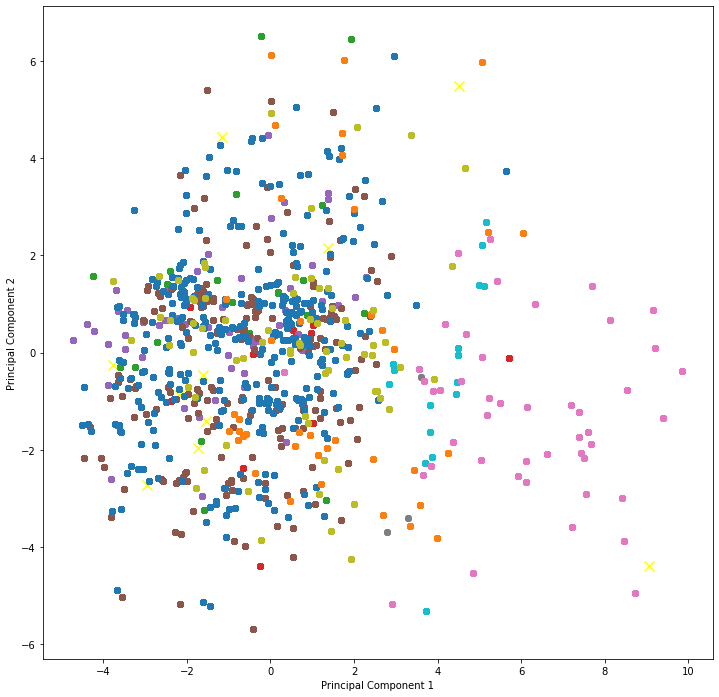

In [ ]:
plt.figure( figsize=(12, 12) )
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.scatter( cluster_centers_reduced.loc[:, 0], cluster_centers_reduced.loc[:, 1], color = "yellow", marker="x", s=100 )
colors = ['tab:blue', 'tab:orange','tab:purple','tab:red','tab:green','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']

for cluster in clusters:
    plt.scatter( df_reduced[df_reduced["cluster"] == cluster].loc[: ,"PC1"], df_reduced[df_reduced["cluster"] == cluster].loc[: ,"PC2"], color = colors[cluster])


### **Cluster 6**
En este cluster se incluyen pokémon de clasificación legendaria tales como Lunala, Solgaleo y Giratina. Como se observa, comparten estadísticos base similares que suman en total 680, por lo que un enfrentamiento entre estos, efectivamente, es balanceado. Cabe destacar que en este cluster (y en todos los demás) no todos los pokémon comparten el mismo total, por ejemplo, Jirachi tiene un total de 600 y pertenece a este cluster, y aun así  es un enfrentamiento factible y balanceado. 

<img src="https://cdn.discordapp.com/attachments/394414976200081412/868722703689981992/Cluster_6.png"/>


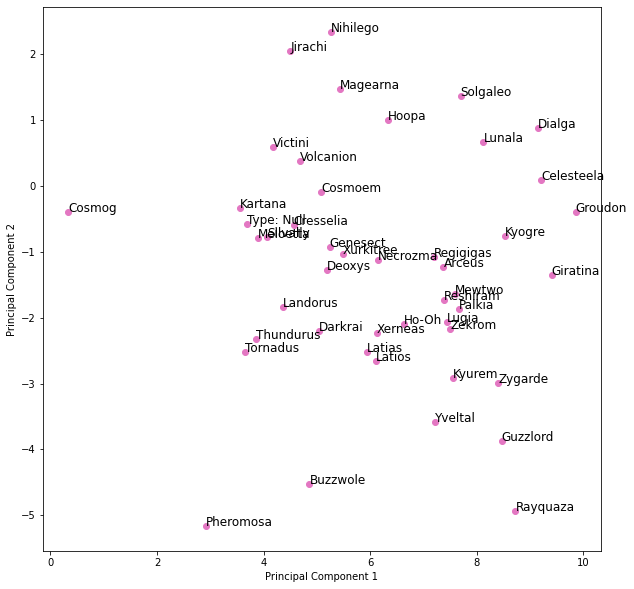

In [ ]:
plt.figure( figsize=(10, 10) )
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
cluster_points = df_reduced[df_reduced["cluster"] == 6]

for index, point in cluster_points.iterrows(): 
    plt.plot( point["PC1"], point["PC2"], "bo", color = colors[6] )
    plt.annotate( point["name"], (point["PC1"], point["PC2"]), fontsize = 12 )


### **Cluster 9**
En este cluster se incluyen pokémon también de clasificación legendaria tales como Articuno, Entei y Registeel, pero cuyos estadísticos base son menores que los del cluster 6 y suman 580, por lo que tiene sentido que no formen parte del mismo. Un enfrentamiento entre estos también es balanceado.

<img src="https://cdn.discordapp.com/attachments/394414976200081412/868724488387301376/unknown.png"/>


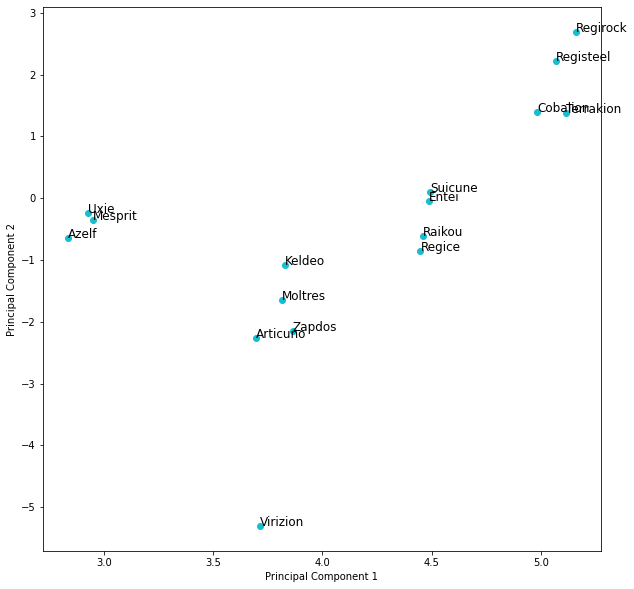

In [ ]:
plt.figure( figsize=(10, 10) )
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
cluster_points = df_reduced[df_reduced["cluster"] == 9]

for index, point in cluster_points.iterrows(): 
    plt.plot( point["PC1"], point["PC2"], "bo", color = colors[9] )
    plt.annotate( point["name"], (point["PC1"], point["PC2"]), fontsize = 12 )

# **Agglomerative Clustering**

## **Tunning de hiperparámetros**
De forma análoga al algoritmo de K-Means, se obtuvo los mejores resultados con 10 clusters, sin embargo, en cuanto a los parámetros de *affinity* y *linkage* se mostraron resultados similares con distintas combinaciones de estos, por ejemplo:
- euclidean affinity - ward linkage (0.9569998126315652)
- l1 affinity - complete linkage (0.9568852809133364)
- l2 affinity - complete linkage (0.9568852809133364) 
 
Como se observa, la primera combinación es mejor, pero no por mucho.



In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
num_clusters_list = [2, 5, 10, 15]
affinity_list = [ "euclidean", "l1", "l2", "manhattan", "cosine", "precomputed"]
linkage_list = ["ward", "complete", "average", "single"]

for num_clusters in num_clusters_list:
  for affinity in affinity_list:
    for linkage in linkage_list:
      try:
        labels = AgglomerativeClustering(n_clusters=num_clusters, affinity=affinity, linkage= linkage).fit_predict(df)
        avg_silhouette = silhouette_score(df, labels)
        print(f"> {num_clusters} clusters - {affinity} affinity - {linkage} linkage ({avg_silhouette})")
      except:
        pass
  print()

> 2 clusters - euclidean affinity - ward linkage (0.7491117881574775)
> 2 clusters - euclidean affinity - complete linkage (0.6771108888076072)
> 2 clusters - euclidean affinity - average linkage (0.7462157716400087)
> 2 clusters - euclidean affinity - single linkage (0.7462157716400087)
> 2 clusters - l1 affinity - complete linkage (0.6771108888076072)
> 2 clusters - l1 affinity - average linkage (0.7462157716400087)
> 2 clusters - l1 affinity - single linkage (0.7462157716400087)
> 2 clusters - l2 affinity - complete linkage (0.6771108888076072)
> 2 clusters - l2 affinity - average linkage (0.7462157716400087)
> 2 clusters - l2 affinity - single linkage (0.7462157716400087)
> 2 clusters - manhattan affinity - complete linkage (0.6771108888076072)
> 2 clusters - manhattan affinity - average linkage (0.7462157716400087)
> 2 clusters - manhattan affinity - single linkage (0.7462157716400087)
> 2 clusters - cosine affinity - complete linkage (0.30817626600260234)
> 2 clusters - cosine af

## **Implementación de modelo**

In [ ]:
from scipy.cluster.hierarchy import dendrogram
from numpy import zeros, column_stack

In [ ]:
pip install --upgrade scikit-learn

In [ ]:
model = AgglomerativeClustering(n_clusters= 10, affinity= "euclidean", linkage= "ward",  compute_distances=True).fit(df)
avg_silhouette = silhouette_score(df, model.labels_)
print(f"> 10 clusters - euclidean affinity - ward linkage ({avg_silhouette})")

> 10 clusters - euclidean affinity - ward linkage (0.9569998126315652)


{'color_list': ['g', 'g', 'g', 'r', 'r', 'r', 'b'],
 'dcoord': [[0.0, 10714.097374460833, 10714.097374460833, 0.0],
  [0.0, 189736.3332185082, 189736.3332185082, 0.0],
  [10714.097374460833,
   1984994.2272923538,
   1984994.2272923538,
   189736.3332185082],
  [0.0, 950305.1518884901, 950305.1518884901, 0.0],
  [0.0, 1124108.390832631, 1124108.390832631, 0.0],
  [950305.1518884901,
   3255390.7430601777,
   3255390.7430601777,
   1124108.390832631],
  [1984994.2272923538,
   4940624.118815688,
   4940624.118815688,
   3255390.7430601777]],
 'icoord': [[5.0, 5.0, 15.0, 15.0],
  [25.0, 25.0, 35.0, 35.0],
  [10.0, 10.0, 30.0, 30.0],
  [45.0, 45.0, 55.0, 55.0],
  [65.0, 65.0, 75.0, 75.0],
  [50.0, 50.0, 70.0, 70.0],
  [20.0, 20.0, 60.0, 60.0]],
 'ivl': ['(10)', '(4)', '(110)', '(62)', '(335)', '(202)', '(22)', '(56)'],
 'leaves': [1572, 1574, 1592, 1593, 1591, 1594, 1584, 1590]}

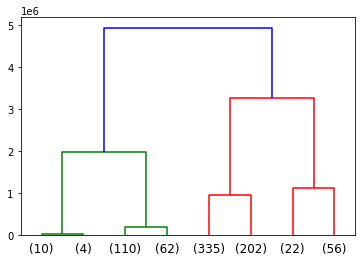

In [ ]:
counts = zeros(model.children_.shape[0])
n_samples = len(model.labels_)

for i, merge in enumerate(model.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = column_stack([model.children_, model.distances_, counts]).astype(float)

dendrogram(linkage_matrix, truncate_mode='level', p=2)